<br> <center> <font size="15" color=Brown>Air Quality Index Analysis</font> </center> <br/>

I have scraped the data from Athena console, through SQL queries. I did initial cleaning there before moving to python.
It is an open datasource, and the information is unsupervised. I selected one country, as the data comes on hourly basis, and is extremely large. There is a word attachement which clarifies the steps.

# Importing Required Libraries



In [ ]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans

<br> <center> <font size="12" color=Orange>Data And Data Manipulation and Cleaning</font> </center> <br/>

# **Reading Data From Google Drive**

## Allow the Access to the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Show the Files of Google Drive

In [ ]:
!ls "/content/drive/My Drive"

 air_data_for_UK_cleaned.csv
 air_quality.csv
'air_quality_index_analysis.ipynb - Colaboratory.pdf'
 Attachment_1605537081.mov
 books
'Colab Notebooks'
 CV.pdf
 dataset_two.csv
'Getting started.pdf'
 metadata.csv
 minute_data_newyork.csv
 My_CV.pdf
'Presentation(Team10_presentation_Final).pptx'
 solution-manual-for-data-communications-and-networking-by-behrouz-forouzan5th-editioncomplete.pdf
 Untitled
'updated ppt.pptx'
 websites.zip


## Reading Dataset One from Google Drive

In [ ]:
!cp "/content/drive/My Drive/air_quality.csv" "air_quality.csv"
air_quality_data = pd.read_csv("air_quality.csv")
air_quality_data.head(5)

,city,date,parameter,unit,coordinates,value
0,Bournemouth,"{utc=2018-07-01T01:00:00.000Z, local=2018-07-0...",o3,µg/m³,"{latitude=50.73957, longitude=-1.826744}",104.0
1,Manchester,"{utc=2018-07-09T11:00:00.000Z, local=2018-07-0...",no2,µg/m³,"{latitude=53.48481, longitude=-2.334139}",17.0
2,Derry,"{utc=2018-07-09T11:00:00.000Z, local=2018-07-0...",o3,µg/m³,"{latitude=55.00282, longitude=-7.331179}",45.0
3,Coventry,"{utc=2018-07-09T11:00:00.000Z, local=2018-07-0...",pm25,µg/m³,"{latitude=52.411564, longitude=-1.560228}",13.0
4,Leominster,"{utc=2018-07-09T11:00:00.000Z, local=2018-07-0...",o3,µg/m³,"{latitude=52.22174, longitude=-2.736665}",48.0


## Reading Dataset Two from Google Drive

For merging two time periods



In [ ]:
!cp "/content/drive/My Drive/dataset_two.csv" "dataset_two.csv"
air_quality_data1 = pd.read_csv("dataset_two.csv")
air_quality_data1.head(5)

,city,date,parameter,unit,coordinates,value
0,London,"{utc=2017-08-11T02:00:00.000Z, local=2017-08-1...",no2,µg/m³,"{latitude=51.54421, longitude=-0.175269}",63.0
1,London,"{utc=2017-08-11T02:00:00.000Z, local=2017-08-1...",so2,µg/m³,"{latitude=51.52253, longitude=-0.154611}",8.0
2,London,"{utc=2017-08-20T05:00:00.000Z, local=2017-08-2...",no2,µg/m³,"{latitude=51.52253, longitude=-0.154611}",53.0
3,Brighton,"{utc=2017-08-19T12:00:00.000Z, local=2017-08-1...",no2,µg/m³,"{latitude=50.840836, longitude=-0.147572}",5.0
4,Reading,"{utc=2017-08-19T12:00:00.000Z, local=2017-08-1...",o3,µg/m³,"{latitude=51.45309, longitude=-0.944067}",42.0


## Merging both Datasets

In [ ]:
air_quality_data = pd.concat([air_quality_data,air_quality_data1])
air_quality_data.head(5)

,city,date,parameter,unit,coordinates,value
0,Bournemouth,"{utc=2018-07-01T01:00:00.000Z, local=2018-07-0...",o3,µg/m³,"{latitude=50.73957, longitude=-1.826744}",104.0
1,Manchester,"{utc=2018-07-09T11:00:00.000Z, local=2018-07-0...",no2,µg/m³,"{latitude=53.48481, longitude=-2.334139}",17.0
2,Derry,"{utc=2018-07-09T11:00:00.000Z, local=2018-07-0...",o3,µg/m³,"{latitude=55.00282, longitude=-7.331179}",45.0
3,Coventry,"{utc=2018-07-09T11:00:00.000Z, local=2018-07-0...",pm25,µg/m³,"{latitude=52.411564, longitude=-1.560228}",13.0
4,Leominster,"{utc=2018-07-09T11:00:00.000Z, local=2018-07-0...",o3,µg/m³,"{latitude=52.22174, longitude=-2.736665}",48.0


# **Data Cleaning**

## Finding and Choosing Top 20 Dominate cities from the dataset

In [ ]:
top_cities = air_quality_data.city.value_counts()
top_cities = pd.DataFrame(top_cities)
top_cities = top_cities.reset_index(drop = False)
cols = top_cities.columns.values
cols[0] = 'city'
cols[1] = 'counts'
top_cities.columns =  cols
top_20_cities_df = top_cities[0:5]
top_20_cities = top_20_cities_df.city.values
air_quality_data_UK = air_quality_data.loc[air_quality_data['city'].isin(top_20_cities)]
air_quality_data_UK = air_quality_data_UK.reset_index(drop = True)
air_quality_data_UK.head(5)

,city,date,parameter,unit,coordinates,value
0,Manchester,"{utc=2018-07-09T11:00:00.000Z, local=2018-07-0...",no2,µg/m³,"{latitude=53.48481, longitude=-2.334139}",17.0
1,London,"{utc=2018-07-06T17:00:00.000Z, local=2018-07-0...",pm25,µg/m³,"{latitude=51.46603, longitude=0.184806}",19.0
2,London,"{utc=2018-07-06T17:00:00.000Z, local=2018-07-0...",pm25,µg/m³,"{latitude=51.52229, longitude=-0.125889}",17.0
3,Glasgow,"{utc=2018-07-01T10:00:00.000Z, local=2018-07-0...",no2,µg/m³,"{latitude=55.85917, longitude=-4.258889}",69.0
4,Manchester,"{utc=2018-07-05T02:00:00.000Z, local=2018-07-0...",pm25,µg/m³,"{latitude=53.48481, longitude=-2.334139}",16.0


## Changing the Date format

In [ ]:
df = pd.DataFrame(air_quality_data_UK.date.str.split(',',1).tolist(),columns = ['Date','date'])
df['Date'] = df['Date'].str[5:]
df['Date'] = pd.to_datetime(df['Date'])
air_quality_data_UK.date = df['Date']
#air_quality_data_UK.date = air_quality_data_UK.date.dt.date
#air_quality_data_UK = air_quality_data_UK.sort_values(by = 'date')
#air_quality_data_UK = air_quality_data_UK.reset_index(drop = True)
air_quality_data_UK.head(5)

,city,date,parameter,unit,coordinates,value
0,Manchester,2018-07-09 11:00:00+00:00,no2,µg/m³,"{latitude=53.48481, longitude=-2.334139}",17.0
1,London,2018-07-06 17:00:00+00:00,pm25,µg/m³,"{latitude=51.46603, longitude=0.184806}",19.0
2,London,2018-07-06 17:00:00+00:00,pm25,µg/m³,"{latitude=51.52229, longitude=-0.125889}",17.0
3,Glasgow,2018-07-01 10:00:00+00:00,no2,µg/m³,"{latitude=55.85917, longitude=-4.258889}",69.0
4,Manchester,2018-07-05 02:00:00+00:00,pm25,µg/m³,"{latitude=53.48481, longitude=-2.334139}",16.0


## Getting Latitude and Longitude

I was initially thinking to create a geograohic cluster, but becouse dtaa is not normally distributed, the map didn't make any sense.

In [ ]:
df = pd.DataFrame(air_quality_data_UK.coordinates.str.split(',',1).tolist(),columns = ['latitude','coordinates'])
df['latitude'] = df['latitude'].str[10:]
df['coordinates'] = df['coordinates'].str[11:]
df['coordinates'] = df['coordinates'].str[:-1]
df['latitude'] = df['latitude'].astype(float)
df['coordinates'] = df['coordinates'].astype(float)
air_quality_data_UK['latitude'] = df['latitude']
air_quality_data_UK['longitude'] = df['coordinates']
del air_quality_data_UK['coordinates']
#air_quality_data_UK['parameter'] = air_quality_data_UK['parameter'] + " " + air_quality_data_UK['unit']
del air_quality_data_UK['unit']
air_quality_data_UK.head(5)


,city,date,parameter,value,latitude,longitude
0,Manchester,2018-07-09 11:00:00+00:00,no2,17.0,53.48481,-2.334139
1,London,2018-07-06 17:00:00+00:00,pm25,19.0,51.46603,0.184806
2,London,2018-07-06 17:00:00+00:00,pm25,17.0,51.52229,-0.125889
3,Glasgow,2018-07-01 10:00:00+00:00,no2,69.0,55.85917,-4.258889
4,Manchester,2018-07-05 02:00:00+00:00,pm25,16.0,53.48481,-2.334139


## Pivot the Dataset based on the column Parameter

In [ ]:
table = pd.pivot_table(air_quality_data_UK, values='value', index=['city','date','latitude','longitude'],columns=['parameter'])
table = table.reset_index()
table.head(5)

parameter,city,date,latitude,longitude,no2,o3,pm10,pm25,so2
0,Glasgow,2016-02-27 21:00:00+00:00,55.859170,-4.258889,114.0,NaN,NaN,NaN,NaN
1,Glasgow,2016-02-27 21:00:00+00:00,55.860935,-4.238214,113.0,NaN,26.0,16.0,NaN
2,Glasgow,2016-02-27 21:00:00+00:00,55.865784,-4.243631,102.0,25.0,22.0,14.0,NaN
3,Glasgow,2016-02-27 21:00:00+00:00,55.872040,-4.270936,87.0,NaN,NaN,NaN,NaN
4,Glasgow,2016-02-27 22:00:00+00:00,55.859170,-4.258889,152.0,NaN,NaN,NaN,NaN


## Shape of the Dataset

In [ ]:
table.shape

(963145, 9)

## Checking the Null values per Column

In [ ]:
table.isnull().sum(axis = 0)

parameter
city              0
date              0
latitude          0
longitude         0
no2          101451
o3           459840
pm10         485374
pm25         381576
so2          757180
dtype: int64

## Filling Null values with the mean of nearest Values

In [ ]:
del table['so2']
air_data_for_UK = table.fillna(table.mean())
air_data_for_UK.head(5)

parameter,city,date,latitude,longitude,no2,o3,pm10,pm25
0,Glasgow,2016-02-27 21:00:00+00:00,55.859170,-4.258889,114.0,40.426853,17.509785,10.525007
1,Glasgow,2016-02-27 21:00:00+00:00,55.860935,-4.238214,113.0,40.426853,26.000000,16.000000
2,Glasgow,2016-02-27 21:00:00+00:00,55.865784,-4.243631,102.0,25.000000,22.000000,14.000000
3,Glasgow,2016-02-27 21:00:00+00:00,55.872040,-4.270936,87.0,40.426853,17.509785,10.525007
4,Glasgow,2016-02-27 22:00:00+00:00,55.859170,-4.258889,152.0,40.426853,17.509785,10.525007


## Saving the Prepared Dataset to the Google Drive

In [ ]:
#air_data_for_UK.to_csv('air_data_for_UK_cleaned.csv',index = False)
#!cp air_data_for_UK_cleaned.csv "drive/My Drive/"

<br> <center> <font size="12" color=Orange>Data Visualizations </font> </center> <br/>

## **Which Cities dominate in the dataset**

Top 5 cities were chosen, as they had solid reporting history. Other cities were not reporting much. 

Text(0.5, 1.0, 'Dominate cities in the dataset')

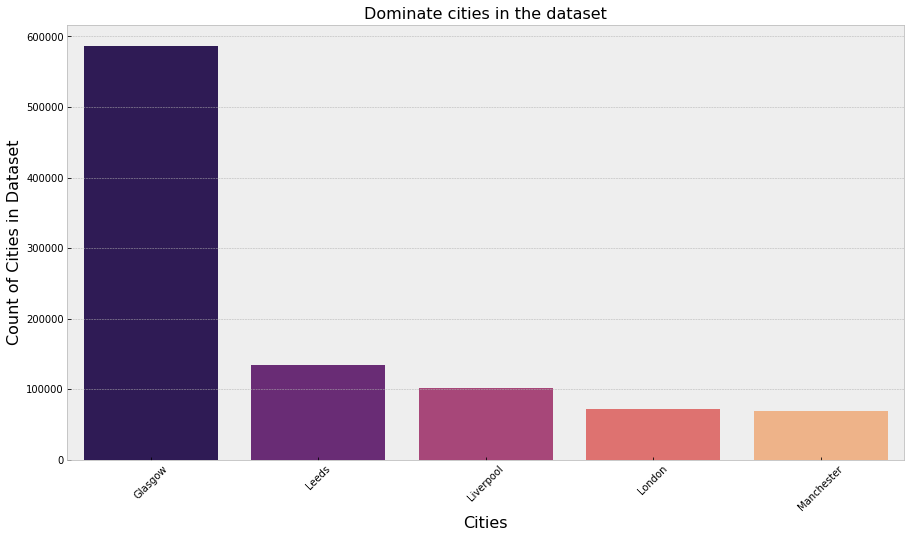

In [ ]:
l = air_data_for_UK.city.value_counts()
n = air_data_for_UK.city.unique()
plt.style.use('bmh')
plt.figure(figsize=(15,8))
sns.barplot(n, l, palette='magma')
plt.xticks(rotation=45)
plt.xlabel('Cities',fontsize=16)
plt.ylabel('Count of Cities in Dataset',fontsize=16)
plt.title("Dominate cities in the dataset",fontsize=16)

test = air_data_for_UK[['date','city','no2']]
test['Year'] = pd.to_datetime(test.date).dt.year
test = test[['city','Year','no2']]
import seaborn as sb
flights = pd.pivot_table(test, values='no2', index=['Year'],columns=['city'])
plt.figure(figsize=(10,8))
plt.xlabel('City',fontsize=16)
plt.ylabel('Years',fontsize=16)
plt.title("Heatmap of no2 per city per Year",fontsize=16)
ax = sns.heatmap(flights)
plt.show()

import seaborn as sb
test1 = air_data_for_UK[['date','city','no2']]
test1['Year'] = pd.to_datetime(test1.date).dt.year
test1 = test1[['city','Year','no2']]
h1 = pd.pivot_table(test1, values='no2', index=['Year'],columns=['city'])


test2 = air_data_for_UK[['date','city','o3']]
test2['Year'] = pd.to_datetime(test2.date).dt.year
test2 = test2[['city','Year','o3']]
h2 = pd.pivot_table(test2, values='o3', index=['Year'],columns=['city'])


fig, (ax1, ax2) = plt.subplots(1,2)
sns.heatmap(h1, ax=ax1)
sns.heatmap(h2, ax=ax2)
plt.show()

## **Mean of Each Attribute Per Year for Each city**

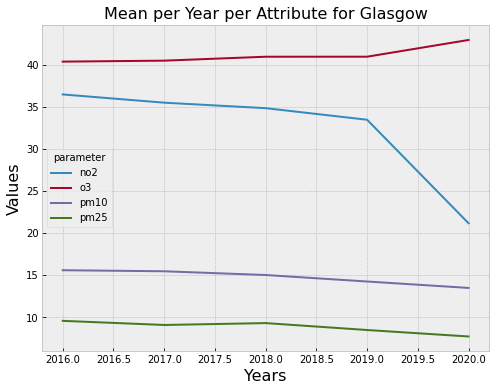

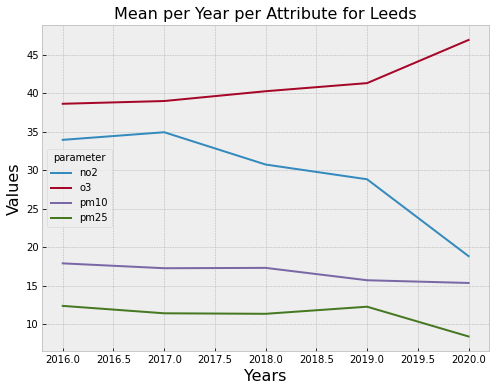

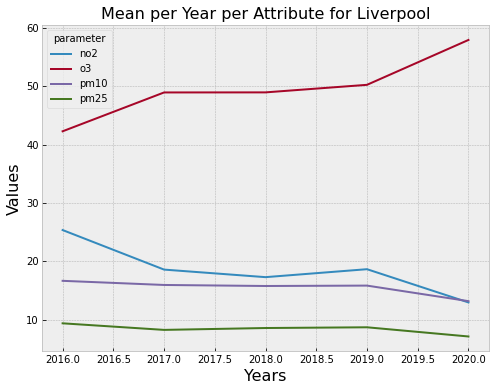

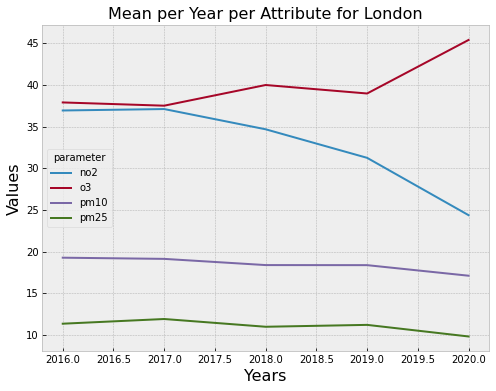

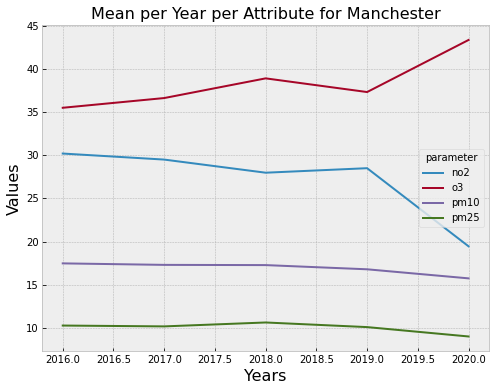

In [ ]:
city_list = air_data_for_UK.city.unique()
i = 0
while i<len(city_list):
  df_per_year = air_data_for_UK[air_data_for_UK['city'] == city_list[i]]
  df_per_year['Year'] = pd.DatetimeIndex(df_per_year['date']).year
  plt.xlabel('Years',fontsize=16)
  plt.ylabel('Values',fontsize=16)
  plt.title("Mean per Year per Attribute for "+city_list[i],fontsize=16)
  sns.lineplot(data = df_per_year.groupby('Year').mean().drop(['latitude', 'longitude'],axis=1),dashes=False)
  plt.gcf().set_size_inches(8, 6)
  plt.show()
  i = i+1

## **Mean of Each Attribute Per Month for Each city**

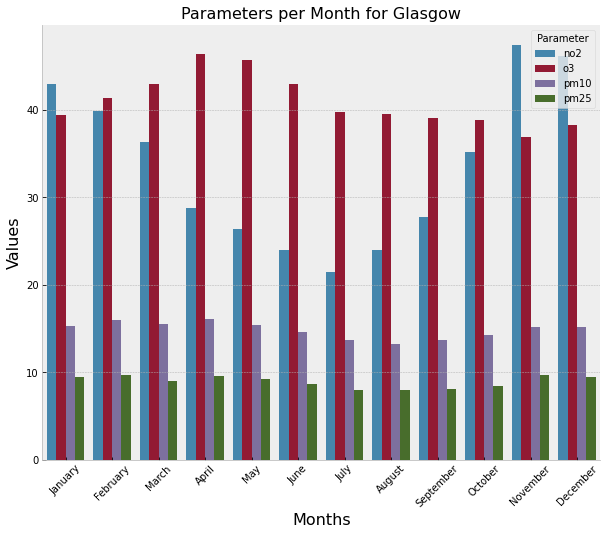

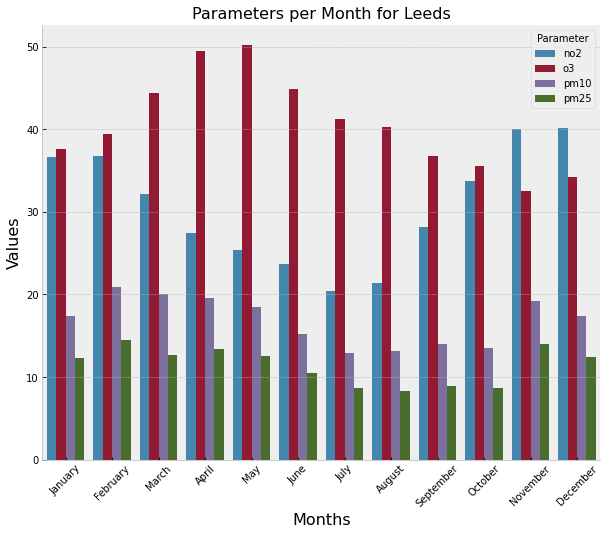

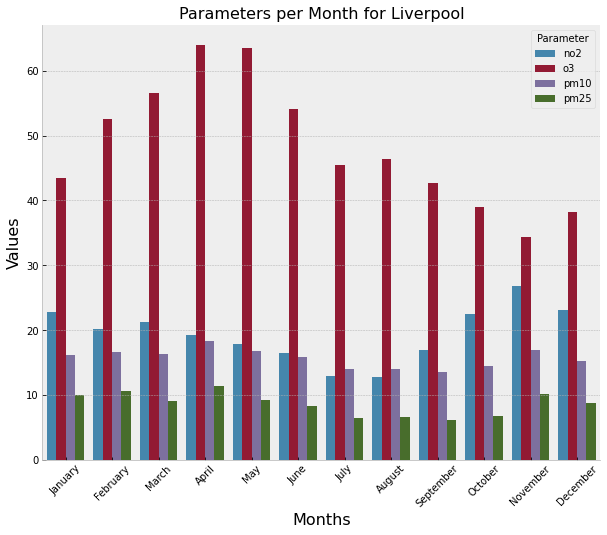

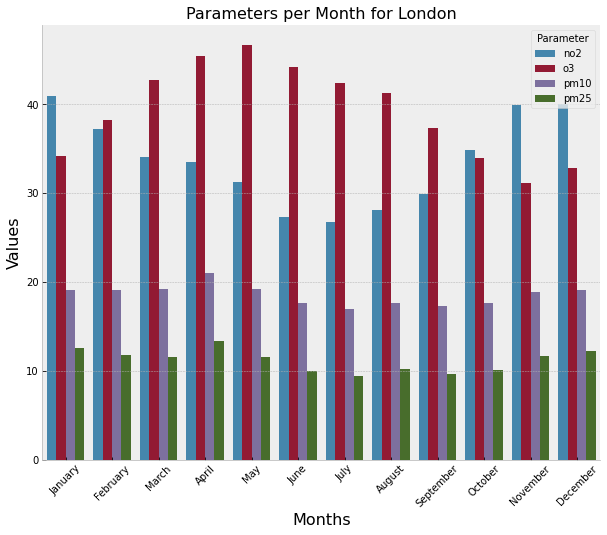

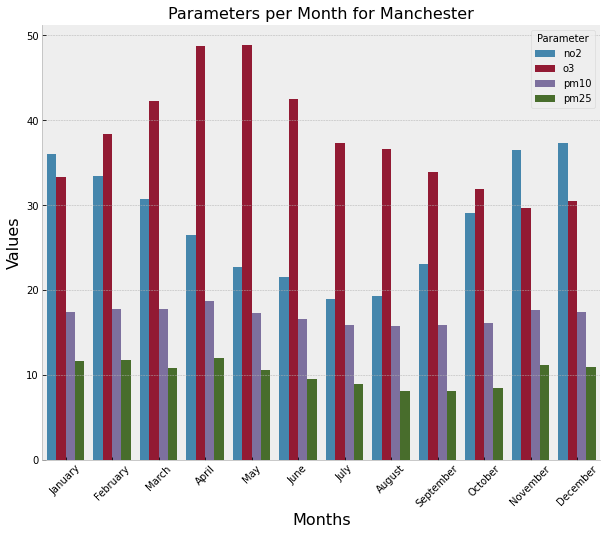

In [ ]:
city_list = air_data_for_UK.city.unique()
i = 0
while i<len(city_list):
  df = air_data_for_UK[air_data_for_UK.city == city_list[i]]
  df['Month'] = pd.to_datetime(df['date']).dt.month_name()
  df['Month_num'] = pd.DatetimeIndex(df['date']).month
  df = df.sort_values(by = 'Month_num')
  df = df.reset_index(drop = True)
  df = df[['Month','no2','o3','pm10','pm25']]
  df_per_mon = df.groupby('Month', sort=False).mean()
  df_per_mon = df_per_mon.reset_index(drop = False)
  test123 = df_per_mon.melt(id_vars='Month').rename(columns=str.title)
  plt.style.use('bmh')
  fig, ax1 = plt.subplots(figsize=(10, 8))
  sns.barplot(x='Month', y='Value', hue='Parameter', data=test123, ax=ax1)
  sns.despine(fig)
  plt.xticks(rotation=45)
  plt.xlabel('Months',fontsize=16)
  plt.ylabel('Values',fontsize=16)
  plt.title("Parameters per Month for "+city_list[i],fontsize=16)
  i = i+1

## **Mean of Each Attribute Per Day for Each city**

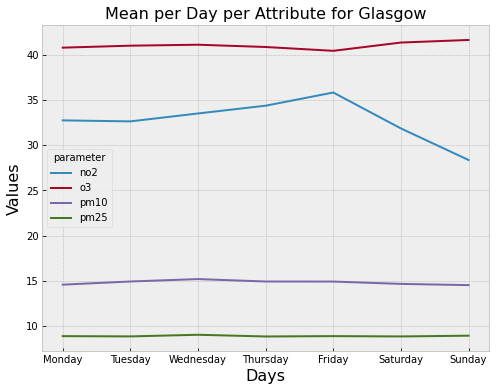

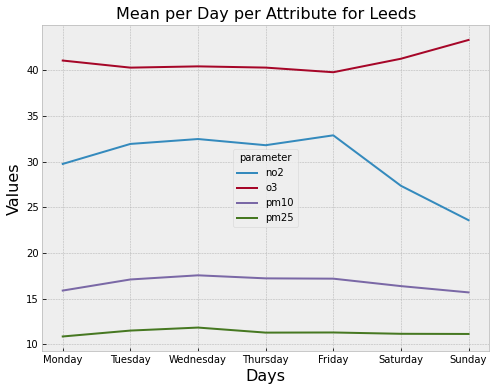

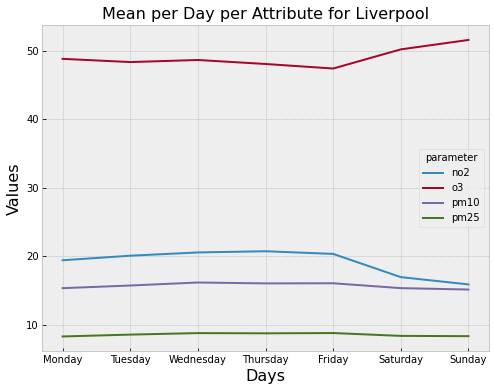

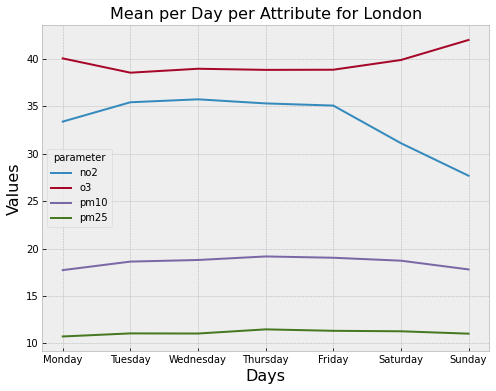

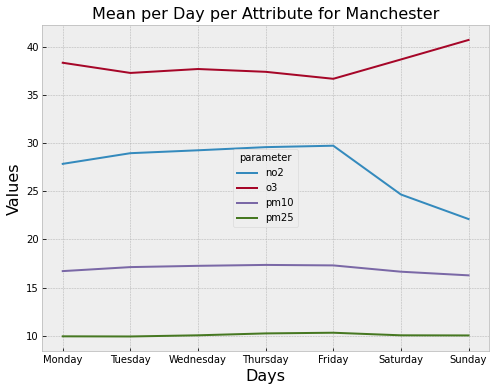

In [ ]:
city_list = air_data_for_UK.city.unique()
i = 0
while i<len(city_list):
  df_per_day = air_data_for_UK[air_data_for_UK['city'] == city_list[i]]
  df_per_day['Day'] = pd.to_datetime(df_per_day['date']).dt.day_name()
  df_per_day['Day_num'] = pd.to_datetime(df_per_day['date']).dt.dayofweek
  df_per_day = df_per_day.sort_values(by = 'Day_num')
  df_per_day = df_per_day.reset_index(drop = True)
  plt.xlabel('Days',fontsize=16)
  plt.ylabel('Values',fontsize=16)
  plt.title("Mean per Day per Attribute for "+city_list[i],fontsize=16)
  sns.lineplot(data = df_per_day.groupby('Day',sort = False).mean().drop(['latitude', 'longitude','Day_num'],axis=1),dashes=False)
  plt.gcf().set_size_inches(8, 6)
  plt.show()
  i = i+1

## **Heatmap Each Attribute Per Hour for Each city**

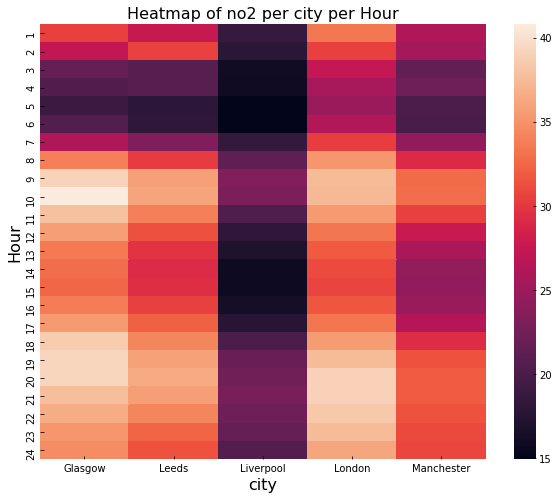

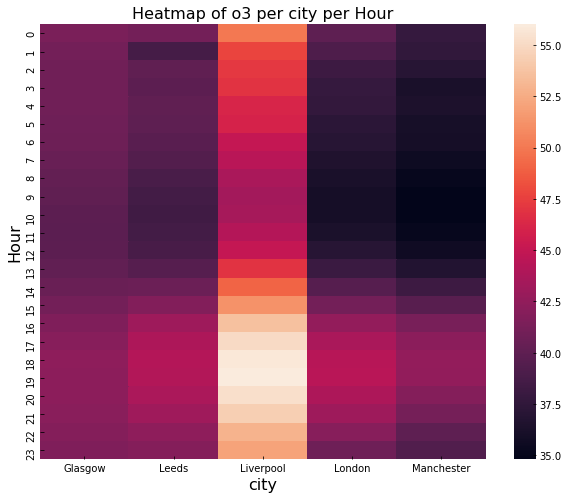

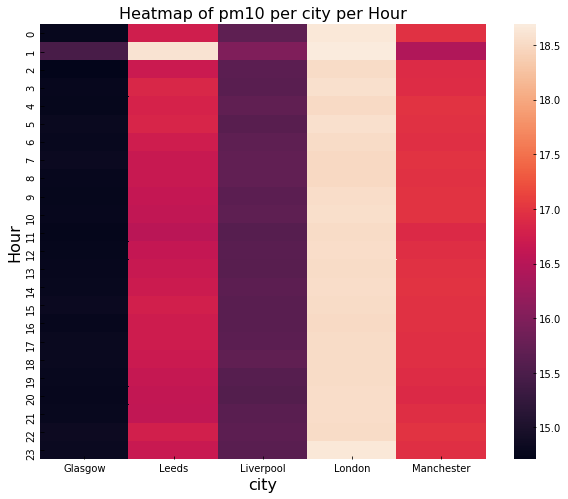

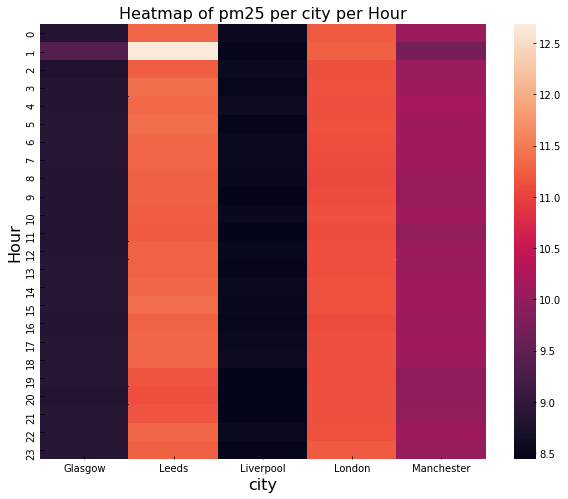

In [ ]:
test = air_data_for_UK[['date','city','no2']]
test['Hour'] = (pd.DatetimeIndex(test['date']).hour)+1
test = test[['city','Hour','no2']]
import seaborn as sb
flights = pd.pivot_table(test, values='no2', index=['Hour'],columns=['city'])
plt.figure(figsize=(10,8))
plt.xlabel('City',fontsize=16)
plt.ylabel('Hour',fontsize=16)
plt.title("Heatmap of no2 per city per Hour",fontsize=16)
ax = sns.heatmap(flights)
plt.show()
test = air_data_for_UK[['date','city','o3']]
test['Hour'] = (pd.DatetimeIndex(test['date']).hour)
test = test[['city','Hour','o3']]
import seaborn as sb
flights = pd.pivot_table(test, values='o3', index=['Hour'],columns=['city'])
plt.figure(figsize=(10,8))
plt.xlabel('City',fontsize=16)
plt.ylabel('Hour',fontsize=16)
plt.title("Heatmap of o3 per city per Hour",fontsize=16)
ax = sns.heatmap(flights)
plt.show()
test = air_data_for_UK[['date','city','pm10']]
test['Hour'] = (pd.DatetimeIndex(test['date']).hour)
test = test[['city','Hour','pm10']]
import seaborn as sb
flights = pd.pivot_table(test, values='pm10', index=['Hour'],columns=['city'])
plt.figure(figsize=(10,8))
plt.xlabel('City',fontsize=16)
plt.ylabel('Hour',fontsize=16)
plt.title("Heatmap of pm10 per city per Hour",fontsize=16)
ax = sns.heatmap(flights)
plt.show()
test = air_data_for_UK[['date','city','pm25']]
test['Hour'] = (pd.DatetimeIndex(test['date']).hour)
test = test[['city','Hour','pm25']]
import seaborn as sb
flights = pd.pivot_table(test, values='pm25', index=['Hour'],columns=['city'])
plt.figure(figsize=(10,8))
plt.xlabel('City',fontsize=16)
plt.ylabel('Hour',fontsize=16)
plt.title("Heatmap of pm25 per city per Hour",fontsize=16)
ax = sns.heatmap(flights)
plt.show()

<br> <center> <font size="12" color=Orange>K Mean Clustering </font> </center> <br/>

# **Finding the Appropriate value of K**

I used k-mean to make sure that there are no annomlaies in the dataset, which would verify above analysis, that a good air qualilty standard is mainatined. 

This is a standard code to determine reasonable number of clusters.

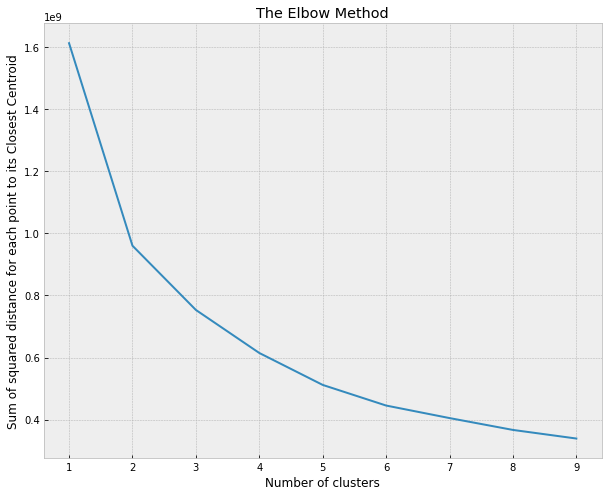

In [ ]:
featured_data = air_data_for_UK[['no2','o3','pm10','pm25']]
# find the appropriate cluster number
plt.figure(figsize=(10, 8))
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(featured_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distance for each point to its Closest Centroid')
plt.show()

# **K Mean Clustering Model**

In [ ]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(featured_data)
centroid = kmeans.cluster_centers_
y_kmeans1=y_kmeans
#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans+1
# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)
# Adding cluster to the Dataset1
featured_data['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(featured_data.groupby('cluster').mean(),1))
kmeans_mean_cluster

parameter,no2,o3,pm10,pm25
cluster,,,,
1,12.6,42.2,14.5,8.5
2,80.7,36.5,21.0,12.2
3,37.8,14.8,18.8,13.0
4,12.8,71.4,16.4,9.4
5,35.1,43.2,18.0,10.6


In [ ]:
Thank you. 